# Nutrition information


The units of the nutrition information are more strictly defined [nutrition information](https://schema.org/NutritionInformation) as comparted to the servings and recipeYield. We however have to be very precise if we want to work with it in our algorithm. We will ook at the 6 most occuring classes for now:

- fatContent
- calories
- sodiumContent
- carbohydrateContent
- cholestorolContent
- proteinContent

In [1]:
import sys
sys.path.append("../code/")
from config import get_mongo_db
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import OrderedDict
db = get_mongo_db()
from IPython.display import HTML, display
import re

%matplotlib inline

## Random sample of recipeYield

In [5]:
p0 = re.compile("(\d+)(?:-\d+)? serving",re.IGNORECASE)
p1 = re.compile("(\d+)",re.IGNORECASE)
p3 = re.compile("\d+\/\d+",re.IGNORECASE)
p2 = re.compile("\d+\s?g",re.IGNORECASE)
def parse_yield(recipeYield, servingSize):
    if recipeYield is not None:
        if servingSize is None or servingSize.strip() == '' or servingSize.strip().lower()[0] == '1' or servingSize == recipeYield or p2.match(servingSize):
            match = p3.search(recipeYield)
            if match is not None:
                return None
            match = p0.search(recipeYield)
            if match:
                return float(match.group(1))
            match = p1.search(recipeYield)
            if match:
                return float(match.group(1))

    return None
print parse_yield("Makes about 1.5 pints",None)

1.0


In [65]:
results = db.recipes.aggregate([{"$match":{"$and":[{"recipeYield":{"$ne":None}},{"context.language":"en"},{"nutritionInfo.calories":{"$ne":None}}]}},{"$sample": {"size":1000}}])
count = 0
determined = 0
html = "<table><tbody><tr>"
for r in results:
    count += 1
    if count % 3 ==0:
        html += "</tr><tr>"
    s = r['recipeYield']
    s += "" if 'servingSize' not in r['nutritionInfo'] else "| <i>%s</i>"% r['nutritionInfo']['servingSize']
    y = parse_yield(r['recipeYield'],None if 'servingSize' not in r['nutritionInfo'] else r['nutritionInfo']['servingSize'])
    if y is not None:
        determined += 1
    html += '<td><a href="%s">%s</a> - %s</td>' % (r['context']['url'],s,y)
html += "</tr></tbody></table>"
display(HTML(html))

## 1,000 random samples for each

In [6]:
classes = ['fatContent','calories','sodiumContent','carbohydrateContent','cholesterolContent','proteinContent']
def find_examples(_class,other_ands=[],number=1000):
    ands = [{"context.language":"en"},{"nutritionInfo."+_class:{"$ne":None}}]
    r = db.recipes.aggregate([{"$match": {"$and": ands}},{"$sample":{"size":number}}])
    return [(x['context']['url'], x['nutritionInfo'][_class]) for x in r]
examples = dict([(k,list(find_examples(k))) for k in classes])

In [7]:
nut0 = re.compile("(\d+)(?: (\d+)\/(\d+))",re.IGNORECASE)
nut1 = re.compile("(\d[\d\.]+)",re.IGNORECASE)

def _make_float(f):
    return float(f.strip())

def parse_nutrition(nutr):
    match = nut0.search(nutr)
    if match:
        return _make_float(match.group(1)) + _make_float(match.group(2)) / _make_float(match.group(3))
    match = nut1.search(nutr)
    if match:
        return _make_float(match.group(1))
    return None
print parse_nutrition("1 1/3 2 2/3")
print parse_nutrition("39g fat (22g saturated fat)")
print parse_nutrition("n/a")
print parse_nutrition("329 calories: 1 serving")
print parse_nutrition("cal. (kcal) 280")

1.33333333333
39.0
None
329.0
280.0


In [103]:
html = "<table><thead><tr>" + "".join(["<td>%s</td>" % h for h in examples.keys()]) +"</tr></thead><tbody>"

for i in xrange(100):
    D = [examples[C][i] for C in classes]
    html += "<tr>" + "".join(['<td><a href="%s">%s</a>[%s]</td>' % (url,x, parse_nutrition(x)) for url,x in D]) + "</tr>"

html +="</tbody></table>"
display(HTML(html))

fatContent,calories,sodiumContent,carbohydrateContent,cholesterolContent,proteinContent
2.8[2.8],200 calories[200.0],939.6[939.6],20[20.0],0.2[0.2],19 g[19.0]
14 g[14.0],472.8[472.8],283.7[283.7],23g carbohydrate (6g sugars[23.0],156.3[156.3],1 grams[1.0]
9.8[9.8],215[215.0],292.1[292.1],50.9[50.9],46.6[46.6],33.4[33.4]
0[0.0],235 calories[235.0],639 mg(27%)[639.0],18g carbohydrate (12g sugars[18.0],65.2[65.2],3g protein. [3.0]
30 g(47%)[30.0],786[786.0],1978.8 mg[1978.8],45.2[45.2],0[0.0],7 g(14%)[7.0]
7.2 g[7.2],270[270.0],1 mg[1.0],32.9[32.9],5mg cholesterol[5.0],5 g[5.0]
12 g[12.0],333[333.0],336 mg(14%)[336.0],19.1g[19.1],45mg cholesterol[45.0],3 g[3.0]
0.9 g (1.5%)[0.9],350[350.0],542.4[542.4],13 g[13.0],39.3[39.3],2.6[2.6]
0 [0.0],400 [400.0],1371[1371.0],"80,2[80.0]",62 mg[62.0],11.5[11.5]
0 g[0.0],636 kcal[636.0],1920 mg[1920.0],45.4[45.4],35 mg[35.0],18 g[18.0]


We see that most sodium and cholesterol is mostly defined in mg, fat, carbohydrate and protein are mostly defined in grams. In most of the cases we can simply extract the number. Where as calories are usually defined in kcal, but sometimes cal. Probably dividing everything above 10000 by 1000 will work. Another observation is that some measurements include the % percentages . 

We look for examples in grams that have "mg" in it and examples of the mg that do have "g" in it but not prefixed with a "m". 

In [8]:
import numpy as np
import seaborn as sns
sns.set(color_codes=True)

def _replace_negative_by_min(L):
    mini = np.min([l for l in L if l > 0.0])
    return [mini if l <= 0.0 else l for l in L]

def plot_dist(_class):
    c2 = db.recipes.find({"context.language":"en","recipeYield":{"$ne":None},("nutritionInfo.%s"%_class):{"$ne":None}})
    tot_dist = []
    per_serving = []
    for recipe in c2:
        try:
            ni = recipe['nutritionInfo']
            y = parse_yield(recipe['recipeYield'],ni['servingSize'] if 'servingSize' in ni else None)
            nut = parse_nutrition(recipe['nutritionInfo'][_class])
            
            if y is not None and nut is not None:
                tot = y * nut 
                tot_dist.append(tot)
                per_serving.append(nut)
        except Exception as e:
            print e
            print recipe['nutritionInfo'][_class]
            print ""
    print len(tot_dist)
    tot_dist = _replace_negative_by_min(tot_dist)
    sns.distplot(np.log10(tot_dist),axlabel="log(%s)"% _class,label="Total %s in recipe" % (_class))
    plt.legend()
    plt.show()
    _class = _class[0].upper() + _class[1:]
    per_serving = _replace_negative_by_min(per_serving)
    sns.distplot(np.log10(per_serving),axlabel="log(%s)"% _class.lower(),color='orange',label="%s in recipe per serving" % (_class))
    plt.legend()
    plt.show()


### Calories

718920


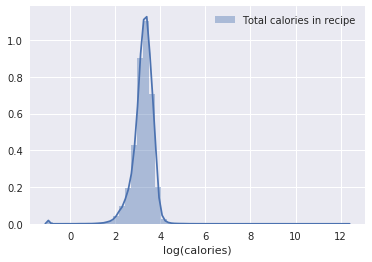

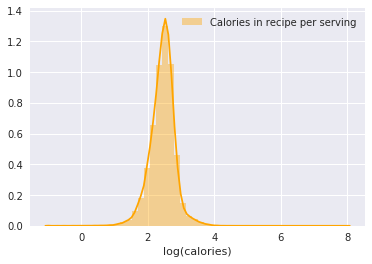

In [9]:
plot_dist('calories')


### Protein content

invalid literal for float(): 2.2.9
2.2.9 G

invalid literal for float(): 2.2.9
2.2.9 G

479611


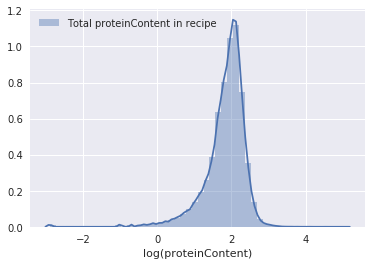

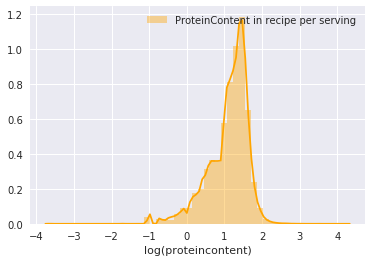

In [10]:
plot_dist('proteinContent')

### Sugar

364314


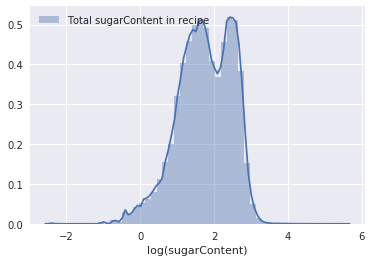

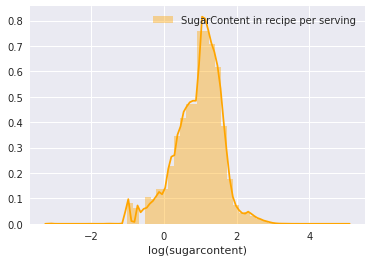

In [11]:
plot_dist('sugarContent')

In [ ]:
X = np.random.normal(100,size=1000)
X2 = np.random.normal(40,size=1000)
sns.distplot(X,axlabel="test",label="Calories per derp herp")
plt.show()
sns.distplot(X2,axlabel="test",label="Calories per we herp")
plt.legend()

### Final stats
After executing `nutr_parser.py`

In [20]:
attrs = ['carbohydrate','cholesterol','fat','fiber','protein','saturatedFat','sodium','sugar','transFat','unsaturatedFat']
attrs = [c+"Content" for c in attrs]
attrs = ["calories"] + attrs
nutr = {}
nutr_rc = {}
ING,REC = (96,24)
for a in attrs:
    
    c = db.recipes.find({"context.language":"en","parsed.recipe_yield":{"$ne":None}, 'max_ingredient_size': {"$lte":ING},'recipe_size':{"$lte":REC},("parsed.%s"%a):{"$ne":None}}).count()
    print "%s & %d \\\\"% (a,c)

def find_union(fields):
    query = [{(("parsed.%s") % f):{"$ne":None}} for f in fields]
    C = db.recipes.find({"context.language":"en","parsed.recipe_yield":{"$ne":None},'max_ingredient_size': {"$lte":ING},'recipe_size':{"$lte":REC}, "$or":query}).count()
    return C
print "%s & %d\\\\" % ("Full dataset", find_union(attrs)) 

calories & 629444 \\
carbohydrateContent & 543376 \\
cholesterolContent & 448716 \\
fatContent & 424972 \\
fiberContent & 278807 \\
proteinContent & 423626 \\
saturatedFatContent & 343708 \\
sodiumContent & 583342 \\
sugarContent & 318749 \\
transFatContent & 9147 \\
unsaturatedFatContent & 5809 \\
Full dataset & 634539\\
